# Config

In [2]:
import numpy as np 
import pickle 
import os 
import torch
import sys
import pandas as pd
from tqdm import tqdm
sys.path.append("/home/haretis/Experience/DeepLearning/TCN/")
from torch import nn
from torch.autograd import Variable
from time import sleep, time 
import matplotlib.pyplot as plt 
from matplotlib.path import Path
import matplotlib.patches as patches
from sklearn.preprocessing import StandardScaler   
from copy import deepcopy
from numpy.random import default_rng 
import argparse
from datetime import datetime
import scipy.signal
from sklearn.decomposition import PCA 
import multiprocessing as mp
from matplotlib.lines import Line2D
import matplotlib as mpl 
from sklearn.datasets import load_iris
from sklearn import tree
import sklearn as sk
rng = default_rng()

In [3]:
font = {'size'   : 18}
mpl.rc('font', **font)

plt.rcParams["figure.figsize"] = (16, 9)

blue = '#332288'
green = '#117733'
light_green = '#44AA99'
light_blue = '#88CCEE'
yellow = '#DDCC77'
red = "#CC6677"
grad = [blue, light_blue, light_green, green, yellow, red, '#AA4499']
default_colors = [light_green, red, light_blue, green, blue, yellow]

# Load data

In [6]:
datapath = "/home/tim/Experiences/Deeplearning/notebooks/data/wall_reflex/datasets/"
dataset_path = "ALP_v3_dataset.pk"

In [7]:
with open(datapath + dataset_path, "rb") as f:
    data = pickle.load(f)

# Analyse

## separate

In [8]:
categories = {"unavoidable": [], "not robust": [],  "robust": [],}
details = {}
for dic in data.values():
    for row in dic["truth"]:
        for res in row:
            if res in details:
                details[res] += 1
            else:
                details[res] = 1
    
    T = dic["map"]
    min_pooled = np.zeros(T.shape)
    for z in range(len(T)):
        for x in range(len(T[z])):
            min_pooled[z,x] = np.min(T[max(0, z-1):z+2, max(0, x-1):x+2])
    if np.sum(min_pooled)>0:
        categories["robust"].append(dic)
    elif np.sum(T)>0:
        categories["not robust"].append(dic)
    else:
        categories["unavoidable"].append(dic)

In [9]:
{key: len(c) for key, c in categories.items()}

{'unavoidable': 630, 'not robust': 618, 'robust': 752}

In [10]:
{key: c for key, c in details.items()}

{'Error': 538893,
 'Fallen_floor': 103072,
 'Fallen_wall': 103718,
 'Falling': 55772,
 'Recovered0': 64358,
 'Recovered5': 4580,
 'Unfallen': 8921,
 'Recovered3': 2673,
 'Recovered1': 13}

# Parallel Plot

## Plot function 

In [11]:
def parallel_plot(data, category, labels, colors=default_colors, title="", bbox_to_anchor=(1.,0,0,0.9)):
    N = len(category)
    ynames = list(data.keys())
    # organize the data
    ys = np.dstack(list(data.values()))[0]
    ymins = ys.min(axis=0)
    ymaxs = ys.max(axis=0)
    dys = ymaxs - ymins
    ymins -= dys * 0.05  # add 5% padding below and above
    ymaxs += dys * 0.05
    dys = ymaxs - ymins
    zs = np.zeros_like(ys)
    zs[:, 0] = ys[:, 0]
    zs[:, 1:] = (ys[:, 1:] - ymins[1:]) / dys[1:] * dys[0] + ymins[0]
    fig, host = plt.subplots(figsize=(16,9))
    axes = [host] + [host.twinx() for i in range(ys.shape[1] - 1)]
    for i, ax in enumerate(axes):
        ax.set_ylim(ymins[i], ymaxs[i])
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        if ax != host:
            ax.spines['left'].set_visible(False)
            ax.yaxis.set_ticks_position('right')
            ax.spines["right"].set_position(("axes", i / (ys.shape[1] - 1)))

    host.set_xlim(0, ys.shape[1] - 1)
    host.set_xticks(range(ys.shape[1]))
    host.set_xticklabels(ynames, fontsize=14)
    host.tick_params(axis='x', which='major', pad=7)
    host.spines['right'].set_visible(False)
    host.xaxis.tick_top()
    host.set_title(title, fontsize=18)
    for j in range(N):
        verts = list(zip([x for x in np.linspace(0, len(ys) - 1, len(ys) * 3 - 2, endpoint=True)], np.repeat(zs[j, :], 3)[1:-1]))
        codes = [Path.MOVETO] + [Path.CURVE4 for _ in range(len(verts) - 1)]
        path = Path(verts, codes)
        patch = patches.PathPatch(path, facecolor='none', lw=1, alpha=0.1, edgecolor=colors[category[j]])
        host.add_patch(patch)

    legend_elements = [Line2D([0], [0], color=color, lw=1, label=label) for (color, label) in zip(colors,labels)]
    host.legend(handles=legend_elements, bbox_to_anchor=bbox_to_anchor)

## NN inputs

In [12]:
selected_categories = ["unavoidable", "robust"]
colors = ["crimson", "forestgreen"]
labels = selected_categories

category = np.concatenate([np.full(len(categories[key]), i) for i, key in enumerate(selected_categories)])
cats = [ categories[key] for key in selected_categories]
data = {
    "wall_angle": np.concatenate([[dic["wall_angle"] for dic in cat] for cat in cats]),
    "wall_distance": np.concatenate([[dic["wall_distance"] for dic in cat] for cat in cats]),
    "rh_x": np.concatenate([[dic["rh"][0] for dic in cat] for cat in cats]),
    "rh_y": np.concatenate([[dic["rh"][1] for dic in cat] for cat in cats]),
    "rh_z": np.concatenate([[dic["rh"][2] for dic in cat] for cat in cats]),
    "lh_x": np.concatenate([[dic["lh"][0] for dic in cat] for cat in cats]),
    "lh_y": np.concatenate([[dic["lh"][1] for dic in cat] for cat in cats]),
    "lh_z": np.concatenate([[dic["lh"][2] for dic in cat] for cat in cats]),
}

In [14]:
#parallel_plot(data, category, colors=colors, labels=labels)

# Arbre de décision

## NN inputs

In [15]:
selected_categories = ["unavoidable", "robust"]
colors = ["crimson", "forestgreen"]
labels = selected_categories

category = np.concatenate([np.full(len(categories[key]), i) for i, key in enumerate(selected_categories)])
cats = [ categories[key] for key in selected_categories]
data = {
    "wall_angle": np.concatenate([[dic["wall_angle"] for dic in cat] for cat in cats]),
    "wall_distance": np.concatenate([[dic["wall_distance"] for dic in cat] for cat in cats]),
    "rh_x": np.concatenate([[dic["rh"][0] for dic in cat] for cat in cats]),
    "rh_y": np.concatenate([[dic["rh"][1] for dic in cat] for cat in cats]),
    "rh_z": np.concatenate([[dic["rh"][2] for dic in cat] for cat in cats]),
    "lh_x": np.concatenate([[dic["lh"][0] for dic in cat] for cat in cats]),
    "lh_y": np.concatenate([[dic["lh"][1] for dic in cat] for cat in cats]),
    "lh_z": np.concatenate([[dic["lh"][2] for dic in cat] for cat in cats]),
}

In [16]:
y = category
X = pd.DataFrame(data)
clf = tree.DecisionTreeClassifier(max_depth=2)
clf = clf.fit(X, y)

In [17]:
# Accuracy
clf.score(X,y)

0.7879884225759769

In [18]:
clf.get_depth()

2

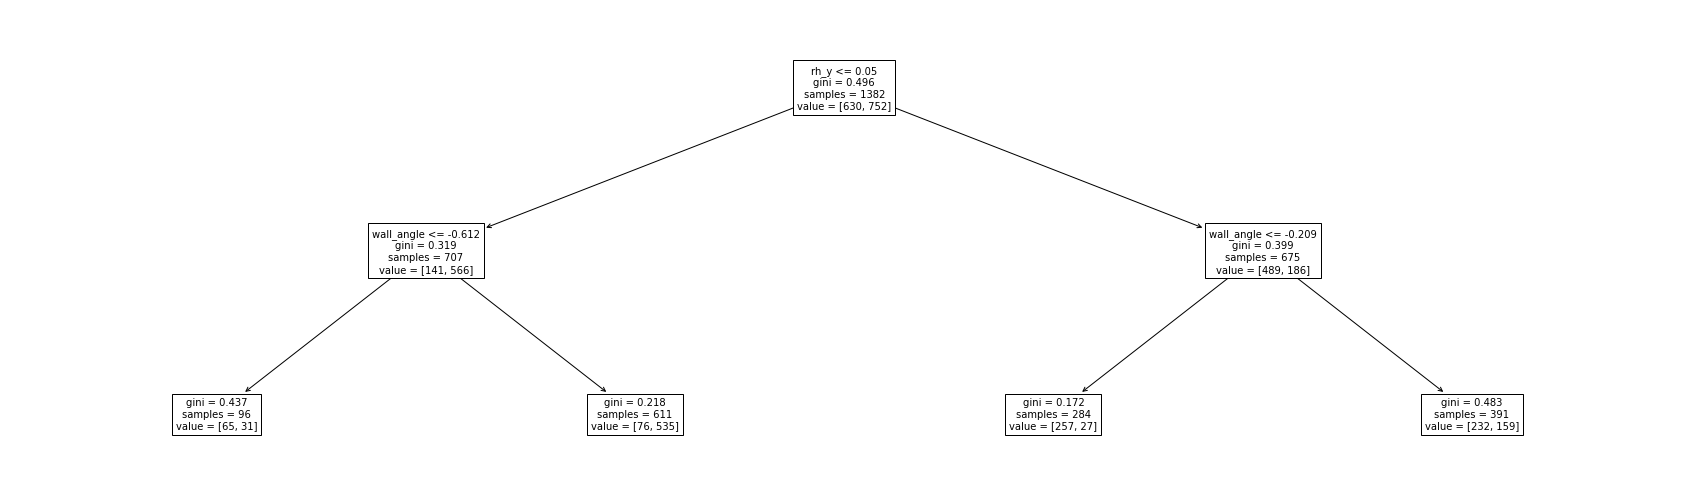

In [19]:
fig, ax = plt.subplots(figsize=(30,9))
tree.plot_tree(clf, ax=ax, fontsize=10, feature_names=list(data.keys()));

## Damages

In [20]:
selected_categories = ["unavoidable", "robust"]
colors = ["crimson", "forestgreen"]
labels = selected_categories

category = np.concatenate([np.full(len(categories[key]), i) for i, key in enumerate(selected_categories)])
cats = [ categories[key] for key in selected_categories]

data = {
    "wall_angle": np.concatenate([[dic["wall_angle"] for dic in cat] for cat in cats]),
    "wall_distance": np.concatenate([[dic["wall_distance"] for dic in cat] for cat in cats]),
    "rh_x": np.concatenate([[dic["rh"][0] for dic in cat] for cat in cats]),
    "rh_y": np.concatenate([[dic["rh"][1] for dic in cat] for cat in cats]),
    "rh_z": np.concatenate([[dic["rh"][2] for dic in cat] for cat in cats]),
    "lh_x": np.concatenate([[dic["lh"][0] for dic in cat] for cat in cats]),
    "lh_y": np.concatenate([[dic["lh"][1] for dic in cat] for cat in cats]),
    "lh_z": np.concatenate([[dic["lh"][2] for dic in cat] for cat in cats]),
}
for damage in [f"Passive_R_Leg_{i}" for i in range(1,7)] + [f"Cut_R_Leg_{i}" for i in range(1,7)] + [f"Locked_R_Leg_{i}" for i in range(1,7)]:
    data[damage] = np.concatenate([[int(damage in dic["condition"]) for dic in cat] for cat in cats])

In [26]:
y = category
X = pd.DataFrame(data)
clf = tree.DecisionTreeClassifier(max_depth=2)
clf = clf.fit(X, y)

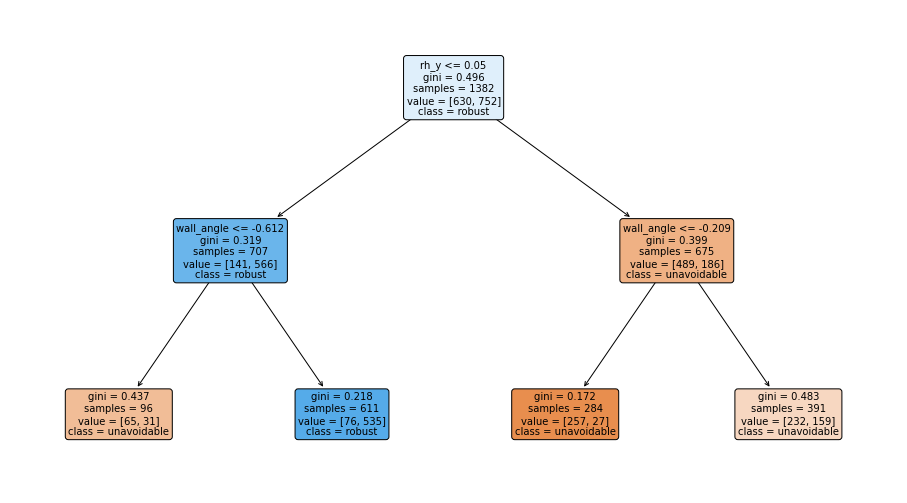

In [27]:
fig, ax = plt.subplots(figsize=(16,9))
tree.plot_tree(clf, ax=ax, fontsize=10, feature_names=list(data.keys()), class_names=["unavoidable", "robust"], filled=True, rounded=True);


In [57]:
489/630,186/752

(0.7761904761904762, 0.2473404255319149)

In [37]:
# Accuracy
clf.score(X,y), clf.get_depth()

(0.8248914616497829, 3)

In [38]:
clf.feature_importances_

array([0.25204654, 0.0245379 , 0.08430242, 0.59512125, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.04399189,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        ])

In [34]:
np.sum(y)/len(y)

0.5441389290882779

## iris example

In [33]:
iris = load_iris()
X, y = iris.data, iris.target
clf = tree.DecisionTreeClassifier(max_depth=2)
clf = clf.fit(X, y)

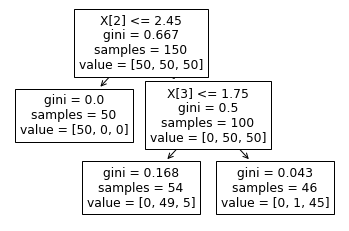

In [34]:
tree.plot_tree(clf);